# Implementation of VZ, RZ, and Hadamard Gates on a Transmon of $n=3$ levels

Our model of the transmon is the Standard Nonlinear Oscillator (SNO) or Duffing Oscillator, which is a cosine potential.

We have $\omega_0 = \sqrt{8 E_c E_J}$, and $\delta = -E_c$ as the transmon anharmonicity. Defining $\omega \equiv \omega_0+\delta$, we see that the transmon levels have energy spacings that each differ by the anharmonicity, as $\omega_{j+1}-\omega_j = \omega + \delta j$, so that $\omega$ corresponds to "the frequency" of the transmon qubit (the transition $\omega_1-\omega_0$). From the definition of the transmon operator, $\hat{c}^\dagger \hat{c} = \sum_j j |j\rangle \langle j|$, we arrive at
$$
\hat{H}_{\rm tr} = \omega \hat{c}^\dagger \hat{c} + \frac{\delta}{2} \hat{c}^\dagger \hat{c} (\hat{c}^\dagger \hat{c} - 1)
 = \sum_j \left(\left(\omega-\frac{\delta}{2}\right)j + \frac{\delta}{2} j^2\right) |j\rangle\langle j| \equiv \sum_j \omega_j |j\rangle \langle j|
$$
so that
$$
\omega_j = \left(\omega-\frac{\delta}{2}\right)j + \frac{\delta}{2} j^2
$$
are the energy levels of the transmon.

We add a drive term (in the qubit subspace this is a pauli X term) that couples adjacent energy levels (assuming higher order coupling is negligible) to perform our pulses. It takes the form
$$
\hat{H}_{\rm dr} = \frac{r \Omega(t)}{2} (\hat{c} + \hat{c}^\dagger)
$$ 
where $r$ is the drive strength and $\Omega(t)$ is the drive signal. Thus our full hamiltonian is
$$
\hat{H} = \hat{H}_{\rm tr} + \hat{H}_{\rm dr} = \omega \hat{c}^\dagger \hat{c} + \frac{\delta}{2} \hat{c}^\dagger \hat{c} (\hat{c}^\dagger \hat{c} - 1) + \frac{r \Omega(t)}{2} (\hat{c} + \hat{c}^\dagger)
$$

### RX Gate

Here we implement a single qubit RX gate with a three level system using a DRAG (derivative removal by adiabatic gate) pulse. Qubit frequency, anharmonicity, and gate time taken from IBM_sherbrooke qubit 74. $sigma$ of the pulse is 1/4 of the pulse duration, by convention. Optimization of the DRAG pulse amplitude can be done with JAX jit compilation or standard scipy scalar function minimization.

In [1]:
import numpy as np
import qiskit.pulse as pulse
from matplotlib import pyplot as plt
from qiskit_dynamics.pulse import InstructionToSignals
from qiskit.quantum_info.operators import Operator
from qiskit_dynamics import Solver, Signal
from matplotlib import pyplot as plt
from qiskit.quantum_info.states import Statevector
from scipy.optimize import minimize, minimize_scalar
import sympy as sym
import jax
jax.config.update("jax_enable_x64", True)

# tell JAX we are using CPU
jax.config.update('jax_platform_name', 'cpu')

import jax.numpy as jnp
from jax import jit, value_and_grad

In [12]:
#Heatmap plot code
from mpl_toolkits.axes_grid1 import AxesGrid
def heatmap2d(arr: np.ndarray):
    # define axes grid
    fig = plt.figure(frameon=False,figsize=(12, 8))
    fig.subplots_adjust(top=0.95)
    grid = AxesGrid(
        fig, 111, 
        nrows_ncols=(1, 2),
        axes_pad=0.5,
        cbar_mode='each',
        cbar_location='right',
        cbar_pad=0.1
    )   
    # plot 
    real_image = grid[0].imshow(np.real(arr), cmap='plasma')
    grid[0].set_title("Real Part of matrix, $\Re{(M)}$", fontsize=20)
    imag_image = grid[1].imshow(np.imag(arr), cmap='plasma')
    grid[1].set_title("Imaginary Part of matrix, $\Im{(M)}$", fontsize=20)
    cbar = grid.cbar_axes[0].colorbar(real_image)
    cbar = grid.cbar_axes[1].colorbar(imag_image)
    plt.show()

For the standard nonlinear oscillator first order DRAG pulse, $\beta = -\frac{\lambda_1^2}{4\delta} = \frac{1}{2\delta}$ where $\lambda_1 = \sqrt{2}$ is the 1-2 relative coupling and $\delta$ is the anharmonicity.

In [212]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel='ibm_quantum', instance="ibm-q/open/main")
backend = service.backend("ibm_sherbrooke")

#qubit_num = 74
qubit_num = 12

w = backend.qubit_properties(qubit_num).frequency * 1E-9 #GHz, qubit frequency
dt = backend.dt * 1E9 #ns, AWG sample time
dur = int(backend.target["sx"][(qubit_num,)].duration * 1E9 / dt) #dt, single gate pulse duration
σ = dur / 4 #convention that duration is 4 sigma
n = 3 #3 level system
d = backend.qubit_properties(qubit_num).anharmonicity * 1E-9 #GHz, anharmonicity
b = - 1 / (2 * d) #ns, DRAG derivative strength
r = 0.1 #GHz, rabi frequency 

w, dt, dur, σ, d, b

(4.62594664766071,
 0.2222222222222222,
 256,
 64.0,
 -0.31372359565205904,
 1.5937596244897507)

Single transmon model class

In [296]:
class Transmon:
    drag_normalization_const = 9
    n = 3 #3 level model
    def __init__(self, qubit_freq, anharmonicity, rabi_strength, pulse_duration, dt, compute_gates = False, channel_num=0):
        self.channel_num=channel_num
        self.w = qubit_freq #GHz
        self.d = anharmonicity #GHz
        self.r = rabi_strength #GHz
        self.dur = pulse_duration #units of dt
        self.β = - 1 / (2 * self.d) #ns
        self.σ = self.dur / 4 #dt
        self.dt = dt #ns

        # construct the solver
        self.hamiltonian_jax_solver = Solver(
            static_hamiltonian=Operator(Transmon.H_transmon(n, self.w, self.d)),
            hamiltonian_operators=[Operator(Transmon.H_drive(n, self.r))],
            rotating_frame=Operator(Transmon.H_transmon(n, self.w, self.d)),
            rwa_carrier_freqs=[self.w],
            #rwa_cutoff_freq=2 * self.w,
            array_library='jax',
            hamiltonian_channels=['d0'],
            channel_carrier_freqs={'d0': self.w},
            dt= self.dt,
            in_frame_basis=True
        )
        # construct the solver
        self.non_jax_solver = Solver(
            static_hamiltonian=Operator(Transmon.H_transmon(n, self.w, self.d)),
            hamiltonian_operators=[Operator(Transmon.H_drive(n, self.r))],
            rotating_frame=Operator(Transmon.H_transmon(n, self.w, self.d)),
            rwa_carrier_freqs=[self.w],
            #rwa_cutoff_freq=2 * self.w,
            #array_library='jax',
            hamiltonian_channels=['d0'],
            channel_carrier_freqs={'d0': self.w},
            dt= self.dt
        )
        if compute_gates: self.store_pulses()


    @classmethod
    def change_num_levels(cls, num: int):
        n = num
    
    def store_pulses(self):
            #Store optimized SX and X pulses for given qubit parameters
            #self.SX_results = minimize_scalar(self.single_transmon_objective, args=(np.pi/2), bounds=(0.,1.))
            #self.SX_pulse = Transmon.drag([self.SX_results.x.item(), self.σ, self.β, self.dur])
            self.SX_pulse = Transmon.drag([Transmon.drag_normalization_const*(np.pi/2) / (2*np.pi*self.r), self.σ, self.β, self.dur])
            with pulse.build(name="SX") as self.SX_gate:
                pulse.play(self.SX_pulse, pulse.DriveChannel(channel_num))
            self.SX_unitary = self.hamiltonian_jax_solver.solve(t_span=[0., self.dur*self.dt], y0=jnp.eye(3, dtype=complex), 
                                        method='jax_odeint', signals=self.SX_gate, atol=1e-8, rtol=1e-8).y[-1]
            self.SX_fidelity = Transmon.fidelity(Transmon.ideal_RX(np.pi/2), self.SX_unitary)
            
            #self.X_results = minimize_scalar(self.single_transmon_objective, args=(np.pi), bounds=(0.,1.))
            #self.X_pulse = Transmon.drag([self.X_results.x.item(), self.σ, self.β, self.dur])
            self.X_pulse = Transmon.drag([Transmon.drag_normalization_const*(np.pi) / (2*np.pi*self.r), self.σ, self.β, self.dur])
            with pulse.build(name="X") as self.X_gate:
                pulse.play(self.X_pulse, pulse.DriveChannel(channel_num))
            self.X_unitary = self.hamiltonian_jax_solver.solve(t_span=[0., self.dur*self.dt], y0=jnp.eye(3, dtype=complex), 
                            method='jax_odeint', signals=self.X_gate, atol=1e-8, rtol=1e-8).y[-1]
            self.X_fidelity = Transmon.fidelity(Transmon.ideal_RX(np.pi), self.X_unitary)

            self.H_gate = self.hadamard()
            self.H_unitary = self.hamiltonian_jax_solver.solve(t_span=[0., self.dur*self.dt], y0=jnp.eye(3, dtype=complex), 
                method='jax_odeint', signals=self.H_gate, atol=1e-8, rtol=1e-8).y[-1]
            self.H_fidelity = Transmon.fidelity(Transmon.ideal_H(), self.H_unitary)
    #Hamiltonian helper functions
    # Standard Nonlinear Oscillator (Duffing) Hamiltonian    
    @staticmethod
    def H_transmon(max_j, w, d):
        H = np.zeros((max_j, max_j))
        for j in range(max_j):
            H[j,j] = 2*np.pi* ( (w - d/2)*(j) + (d/2)*(j**2) - w/2)
        return H
    
    #X drive hamiltonian
    @staticmethod
    def H_drive(max_j, r):
        H = np.zeros((max_j, max_j))
        for j in range(max_j - 1):
            #λ_1 = sqrt(2)
            H[j,j+1] = np.sqrt(j+1)
            H[j+1,j] = np.sqrt(j+1)
        return 2*np.pi * (r / 2) * H


    # #JAX compatible lifted gaussian pulse
    # @staticmethod
    # def lifted_gaussian(
    #     t: sym.Symbol,
    #     center,
    #     t_zero,
    #     sigma,
    # ) -> sym.Expr:
    #     t_shifted = (t - center).expand()
    #     t_offset = (t_zero - center).expand()

    #     gauss = sym.exp(-((t_shifted / sigma) ** 2) / 2)
    #     offset = sym.exp(-((t_offset / sigma) ** 2) / 2)

    #     return (gauss - offset) / (1 - offset)


    # #JAX compatible drag pulse
    # @staticmethod
    # def drag(params):
    #     amp, sigma, beta, duration = params
    #     _t, _duration, _amp, _sigma, _angle, _beta = sym.symbols("t, duration, amp, sigma, angle, beta")
    #     _center = _duration / 2
    #     envelope_expr = (_amp * sym.exp(sym.I * _angle) * Transmon.lifted_gaussian(_t, _center, _duration + 1, _sigma)
    #                     * (1+ 1j * _beta * (_t - _center)/(_sigma**2)))

    #     pulse.ScalableSymbolicPulse.disable_validation = True
    #     return pulse.ScalableSymbolicPulse(
    #             pulse_type="DRAG",
    #             duration= duration,
    #             angle=0,
    #             amp=amp,
    #             parameters={"sigma": sigma, "beta": beta},
    #             envelope=envelope_expr,
    #             constraints=sym.And(_sigma > 0, _beta > 0),
    #             valid_amp_conditions=sym.Abs(_amp) <= 1.0,
    #         )
    
    def lifted_gaussian(
        t: sym.Symbol,
        center,
        t_zero,
        sigma,
    ) -> sym.Expr:
        t_shifted = (t - center).expand()
        #t_offset = (t_zero - center).expand()

        gauss = sym.exp(-((t_shifted / sigma) ** 2) / 2)
        offset = sym.exp(-((t_zero / sigma) ** 2) / 8)

        return (gauss - offset) / (sym.sqrt(2*np.pi* sigma**2) * sym.erf(t_zero/(sym.sqrt(8)*sigma)) - t_zero*offset)


    #JAX compatible drag pulse

    def drag(params):
        amp, sigma, beta, duration = params
        _t, _duration, _amp, _sigma, _angle, _beta = sym.symbols("t, duration, amp, sigma, angle, beta")
        _center = _duration / 2
        envelope_expr = (_amp * sym.exp(sym.I * _angle) * Transmon.lifted_gaussian(_t, _center, _duration + 1, _sigma)
                        * (1+ 1j * _beta * (_t - _center)/(_sigma**2)))

        pulse.ScalableSymbolicPulse.disable_validation = True
        return pulse.ScalableSymbolicPulse(
                pulse_type="DRAG",
                duration= duration,
                angle=0,
                amp=amp,
                parameters={"sigma": sigma, "beta": beta},
                envelope=envelope_expr,
                constraints=sym.And(_sigma > 0, _beta > 0),
                valid_amp_conditions=sym.Abs(_amp) <= 1.0,
            )

    @staticmethod
    def ideal_RX(θ):
        return jnp.array([[np.cos(θ/2), -1j*np.sin(θ/2), 0],
                        [-1j*np.sin(θ/2), np.cos(θ/2), 0],
                        [0, 0, 1]])

    @staticmethod
    def ideal_H():
        return (1/np.sqrt(2))*np.array([[1, 1, 0],
                        [1, -1, 0],
                        [0, 0, np.sqrt(2)]])

    @staticmethod
    def fidelity(ideal_gate , U):
        return jnp.abs(jnp.trace((ideal_gate.conj().T @ U)[0:2,0:2]))**2 / 4
        #return jnp.abs(jnp.trace((ideal_gate.conj().T @ U)))**2 / n**2
    

    def single_transmon_objective(self, amp, θ):
        #generate rx pulse schedule  
        with pulse.build(name="RX") as r_x:
            pulse.play(Transmon.drag([amp, self.σ, self.β, self.dur]), pulse.DriveChannel(0))

        #solve dynamics
        sol = self.hamiltonian_jax_solver.solve(t_span=[0., self.dur*self.dt], y0=jnp.eye(3, dtype=complex), 
                                        method='jax_odeint', signals=r_x, atol=1e-8, rtol=1e-8)

        u = sol.y[-1]
        return 1. - Transmon.fidelity(Transmon.ideal_RX(θ), u)


    def opt_RX(self, θ, x0=0.1634):
        opt_results = minimize_scalar(self.single_transmon_objective, args=(θ), bounds=(0.,1.))
        #Optionally, can use JAX compilation for optimization - not much faster for single variable
        #jit_grad_obj = jit(value_and_grad(single_transmon_objective))
        #opt_results = minimize(fun=jit_grad_obj, x0= x0, jac=True, method='BFGS')

        #generate rx pulse schedule  
        with pulse.build(name="RX") as r_x:
            pulse.play(self.drag([opt_results.x.item(), self.σ, self.β, self.dur]), pulse.DriveChannel(0))
        
        return opt_results, r_x
    
    def gen_RX_pulse(self, θ):
        return self.drag([Transmon.drag_normalization_const*(θ) / (2*np.pi*self.r), self.σ, self.β, self.dur])

    def hadamard(self, x0=0.1634):
        #opt_results2 = minimize_scalar(self.single_transmon_objective, args=(np.pi), bounds=(0.,1.))
        with pulse.build(name="Hadamard") as hgate:
            #pulse.delay(10, pulse.DriveChannel(0))
            pulse.shift_phase(-np.pi/2, pulse.DriveChannel(channel_num))
            pulse.play(Transmon.drag([Transmon.drag_normalization_const*(np.pi/2) / (2*np.pi*self.r), self.σ//2, 
                                  self.β, self.dur//2]), pulse.DriveChannel(channel_num))
            pulse.shift_phase(-np.pi/2, pulse.DriveChannel(channel_num))
            pulse.play(Transmon.drag([Transmon.drag_normalization_const*(np.pi) / (2*np.pi*self.r), self.σ//2, 
                                  self.β, self.dur//2]), pulse.DriveChannel(channel_num))        
            return hgate

    #initial state can be a statevector or operator
    def solve_dynamics(self, initial_state, gate_pulse, plot_pops=True, JAXmethod = False):
        #solve dynamics
        if JAXmethod == True:
            sol = self.hamiltonian_jax_solver.solve(t_span=[0., gate_pulse.duration*self.dt], method='jax_odeint',
                                            y0 = initial_state, signals=gate_pulse, atol=1e-8, rtol=1e-8)
        else:
            sol = self.non_jax_solver.solve(t_span=[0., gate_pulse.duration*self.dt], 
                                            y0 = initial_state, signals=gate_pulse, atol=1e-8, rtol=1e-8)
            
        if plot_pops: Transmon.plot_populations(sol, gate_pulse.duration*self.dt)
        return sol
    
    #Plot code
    @staticmethod    
    def plot_populations(sol, max_t):
        pop0 = [psi.probabilities()[0] for psi in sol.y]
        pop1 = [psi.probabilities()[1] for psi in sol.y]
        pop2 = [psi.probabilities()[2] for psi in sol.y]


        fig = plt.figure(figsize=(8, 5))
        plt.plot(sol.t, pop0, lw=3, label="|0>")
        plt.plot(sol.t, pop1, lw=3, label="|1>")
        plt.plot(sol.t, pop2, lw=3, label="|2>")
        plt.xlabel("Time (ns)")
        plt.ylabel("Probability")
        plt.legend(frameon=False)
        plt.ylim([0, 1.05])
        plt.xlim([0, max_t])
        plt.grid()
        #plt.vlines(T, 0, 1.05, "k", linestyle="dashed")

SX Gate

In [297]:
ex = Transmon(qubit_freq=w, anharmonicity=d, rabi_strength=r, pulse_duration=dur, dt=dt, compute_gates=True)
1-ex.SX_fidelity.item()

3.8578256733590166e-07

Text(0.5, 1.0, 'SX Gate DRAG Pulse, error =  3.86e-07, leakage =  2.74e-08')

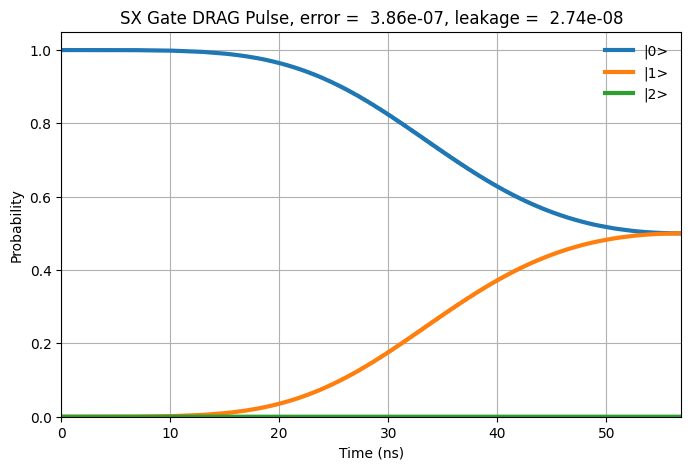

In [281]:
ground_state = Statevector([1.,0,0])
solSX = ex.solve_dynamics(ground_state, ex.SX_gate)
plt.title(f'SX Gate DRAG Pulse, error = {1.-ex.SX_fidelity: .3g}, leakage = {solSX.y[-1].probabilities()[2]: .3g}')

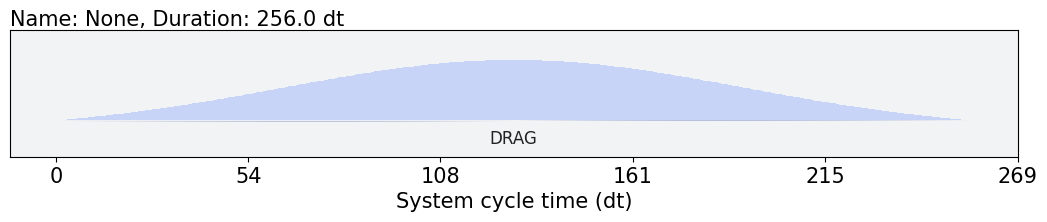

In [282]:
ex.SX_pulse.draw()

X Gate

In [286]:
#X_results, X_pulse = ex.opt_RX(np.pi)
1-ex.X_fidelity.item()

2.5155664140630307e-06

Text(0.5, 1.0, 'X Gate DRAG Pulse, error =  2.52e-06, leakage =  2.32e-07')

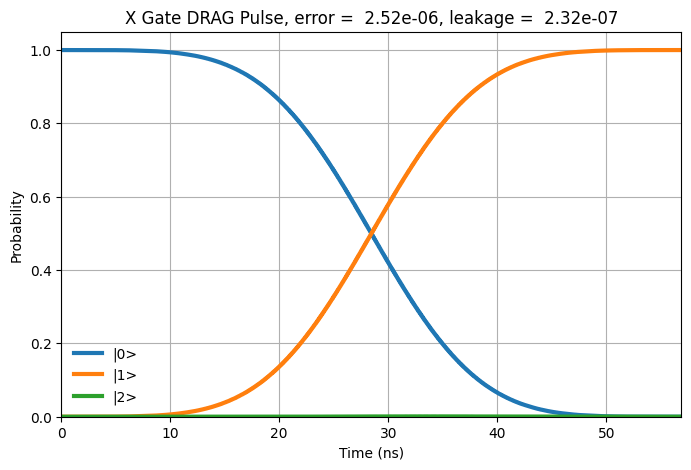

In [287]:
solX = ex.solve_dynamics(ground_state, ex.X_gate)
plt.title(f'X Gate DRAG Pulse, error = {1.-ex.X_fidelity: .3g}, leakage = {solX.y[-1].probabilities()[2]: .3g}')

Hadamard Gate

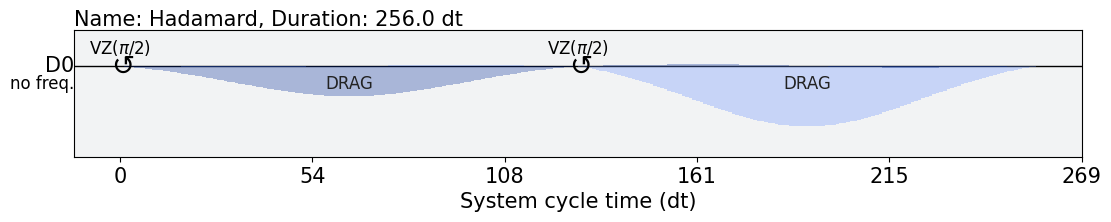

In [293]:
ex.H_gate.draw()

Text(0.5, 1.0, 'Hadamard Gate, error =  1.24e-05, leakage =  3.19e-06')

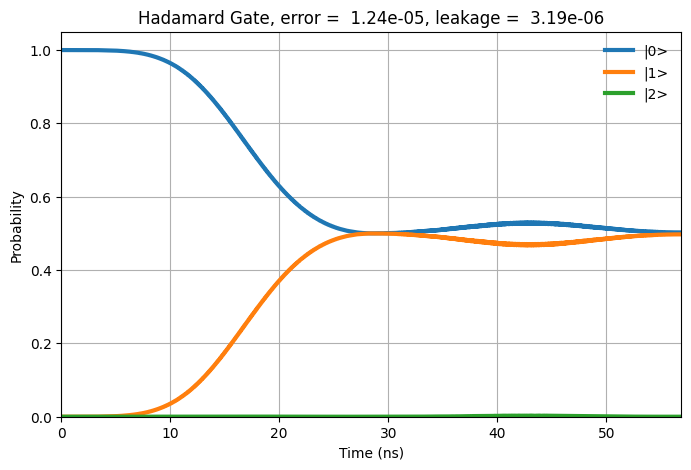

In [298]:
solH = ex.solve_dynamics(ground_state, ex.H_gate, plot_pops=True)
plt.title(f'Hadamard Gate, error = {1.-ex.H_fidelity: .3g}, leakage = {solH.y[-1].probabilities()[2]: .3g}')

In [299]:
solH = ex.solve_dynamics(jnp.eye(3, dtype=complex), ex.H_gate, plot_pops=False, JAXmethod=True)
H_fidelity = Transmon.fidelity(Transmon.ideal_H(), solH.y[-1])
H_fidelity.item()

0.9999876033646328

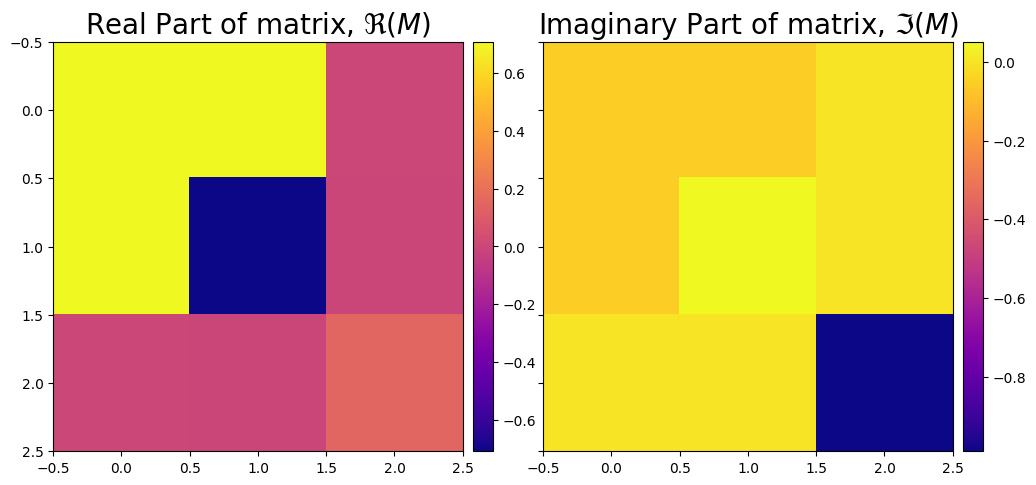

In [300]:
heatmap2d(-1j*solH.y[-1])

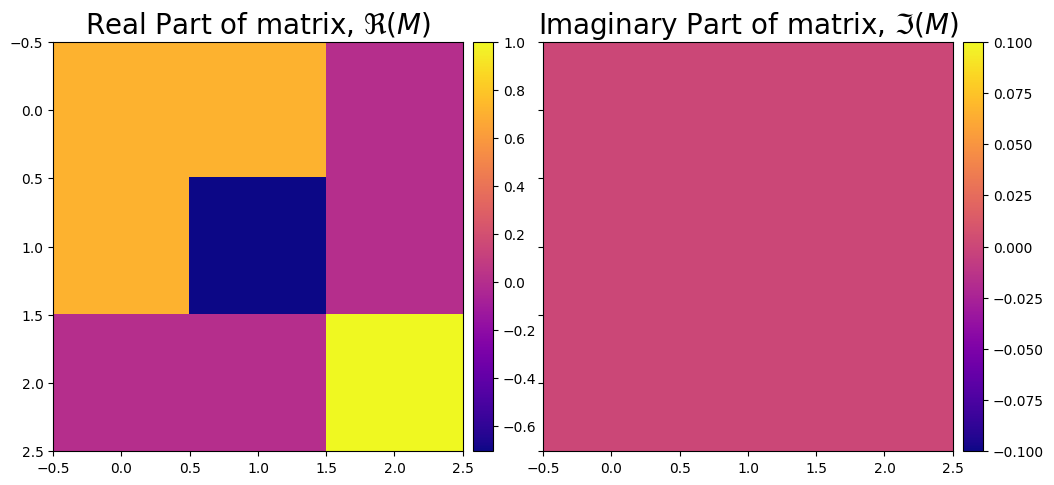

In [280]:
heatmap2d(Transmon.ideal_H())

Finding DRAG pulse normalization constant

In [217]:
#JAX compatible lifted gaussian pulse

def lifted_gaussian2(
    t: sym.Symbol,
    center,
    t_zero,
    sigma,
) -> sym.Expr:
    t_shifted = (t - center).expand()
    #t_offset = (t_zero - center).expand()

    gauss = sym.exp(-((t_shifted / sigma) ** 2) / 2)
    offset = sym.exp(-((t_zero / sigma) ** 2) / 8)

    return (gauss - offset) / (sym.sqrt(2*np.pi* sigma**2) * sym.erf(t_zero/(sym.sqrt(8)*sigma)) - t_zero*offset)


#JAX compatible drag pulse

def drag2(params):
    amp, sigma, beta, duration = params
    _t, _duration, _amp, _sigma, _angle, _beta = sym.symbols("t, duration, amp, sigma, angle, beta")
    _center = _duration / 2
    envelope_expr = (_amp * sym.exp(sym.I * _angle) * lifted_gaussian2(_t, _center, _duration + 1, _sigma)
                    * (1+ 1j * _beta * (_t - _center)/(_sigma**2)))

    pulse.ScalableSymbolicPulse.disable_validation = True
    return pulse.ScalableSymbolicPulse(
            pulse_type="DRAG",
            duration= duration,
            angle=0,
            amp=amp,
            parameters={"sigma": sigma, "beta": beta},
            envelope=envelope_expr,
            constraints=sym.And(_sigma > 0, _beta > 0),
            #valid_amp_conditions=sym.Abs(_amp) <= 1.0,
        )

r2 = r
ex2 = Transmon(qubit_freq=w, anharmonicity=d, rabi_strength=r2, pulse_duration=dur, dt=dt, compute_SX_X_gates=True)

def test_obj(amp):

    with pulse.build() as test_pulse:
        pulse.play(drag2([amp*(np.pi) / (2*np.pi*r2), σ, b, dur]), pulse.DriveChannel(0))

    sol_test = ex2.solve_dynamics(jnp.eye(3, dtype=complex), test_pulse, plot_pops=False, JAXmethod=True)
    #sol_test = ex.solve_dynamics(ground_state, test_pulse, plot_pops=True, JAXmethod=False)

    return 1. - Transmon.fidelity(Transmon.ideal_RX(np.pi), sol_test.y[-1])

minimize_scalar(test_obj, bounds=(8.6,9.1))


 message: Solution found.
 success: True
  status: 0
     fun: 2.3694750345137905e-06
       x: 9.001972976750414
     nit: 15
    nfev: 15

In [219]:
test_obj(9)

Array(2.51556641e-06, dtype=float64)

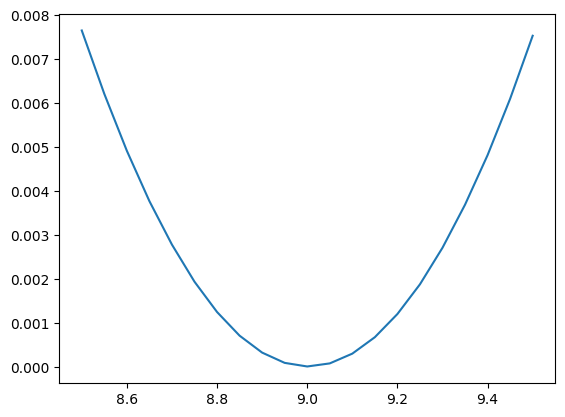

In [218]:
amps = np.linspace(8.5,9.5, 21)
objs = [test_obj(amp) for amp in amps]
plt.plot(amps, objs)

In [160]:
from sympy import integrate
t = sym.Symbol('t')
integrate(lifted_gaussian2(t, 0.5*dur/2, 0.5*(dur+1), 0.5*dur/4), (t, 0, 0.5*dur)).evalf()

0.999991185697612